# "Education" solution (DataFusion2022 track №3)¶

For the first let's check available resources

In [1]:
import multiprocessing
from psutil import virtual_memory

print(f"CPU: {multiprocessing.cpu_count()}")
print(f"RAM {round(virtual_memory().total / 1024**3, 1)} Gb")

CPU: 2
RAM 15.5 Gb


There is one main data file:

- transactions.csv, that can be fully put into RAM but in some transformation cases memory lack might be.

That's why it was decided to provide an initial preprocessing. An initial preprocessing is splitting data file by 1_000_000 elements volume in each files and converting it into ".parquet" extension.  
So after it there are 20 files.  
In this notebook I'll use these files

## 0 Importing necessary modules

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import trange, tqdm
from lightautoml.tasks import Task
from joblib import Parallel, delayed
from IPython.core.display import display
from lightautoml.automl.presets.tabular_presets import TabularUtilizedAutoML

tqdm.pandas()
warnings.filterwarnings('ignore')

# Initialising path for auxiliary files
MAIN_PATH = os.getcwd()

Let's create necessary functions for:

- feature engineering;
- feature transformation;
- submission generation

In [3]:
def gen_features(data):
    
    """
    This function is intended for feature engineering. Sum, mean and count features of
    'mcc_code' are created taking in account all possible values of 'mcc_code'.
    The function produces data type changing aiming to reduce usable memory usage and
    prints new data shape and memory usage.
    Input:
    - data [pandas.DataFrame] - an initial data.
    Output:
    - data with new features [pandas.DataFrame].
    """
        
    df = data.pivot_table(index = 'user_id', values=['transaction_amt'], columns=['mcc_code'],
                          aggfunc=['sum','mean', 'count']).fillna(0)
    df.columns = [f'{i[0]}-{str(i[2])}' for i in df.columns]
    
    dtypes = [np.where('count' in col, 'int16', 'float32').tolist() for col in df.columns]   
    dtypes = dict(zip(df.columns.tolist(), dtypes))
    df = df.astype(dtypes)

    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage().sum() // 1024 ** 2} Mb")
    
    return df

In [4]:
def binarize_count_features(data):
    
    """
    This function is intended for 'count' features binaziration. The main indicator of
    binarization is Pearson correlation coefficient. If dummy feature has greater
    correlation coefficient than the main feature then dummy feature will replace the main one.
    Input:
    - data [pandas.DataFrame] - an initial data.
    Output:
    - data with binarized 'count' features[pandas.DataFrame].
    """
    
    count_cols = [col for col in data.columns if 'count' in col]
    print(f"Total amount of 'count' features: {len(count_cols)}")

    columns = []
    for idx, col in tqdm(enumerate(count_cols)):
    
        corr_ = np.abs(data.loc[:, [col, 'higher_education']].corr()['higher_education'][0])
        data['dummy'] = np.where(data[col]>0, 1, 0)
        dummy_corr = np.abs(data.loc[:, ['dummy', 'higher_education']].corr()['higher_education'][0])

        if dummy_corr / corr_ > 1.0:

            data[col] = data['dummy']
            data[col] = data[col].astype('int8')
            columns.append(col)
        
    data.drop(['dummy'], axis=1, inplace=True)

    print(f"Binarized: {len(columns)}")
    print(f"Memory usage: {data.memory_usage().sum() // 1024 ** 2} Mb")
    
    return columns

In [5]:
def make_submit(data, predictions):
    
    """
    This function is intended for generating file with predictions.
    The function prints first 10 samples of the submission data.
    Input:
    - data [pandas.DataFrame] - data with necessary indexes;
    - predictions [list / numpy.array] - probability predictions.
    Output:
    - None.
    """
    
    submit = pd.DataFrame(columns=['bank'], data=data.index.to_list())
    
    submit['higher_education_proba'] = 0
    submit['higher_education_proba'] = predictions
    submit['higher_education_proba'] = submit['higher_education_proba'].astype('float64')
    
    display(submit.head(10))
    
    submit.to_csv('education_sub.csv', index=False)
    
    print("Done")

## 1 Data loading

Let's load train data and create at once dictionary that contain "user to education" mapping

In [6]:
%%time

he_train = pd.read_csv('train_education.csv')
education_mapping = dict(zip(he_train['bank'].values, he_train['higher_education'].values))
print(len(education_mapping))

del he_train

8509
Wall time: 53 ms


Let's look at distribution of target variable - presence education fact

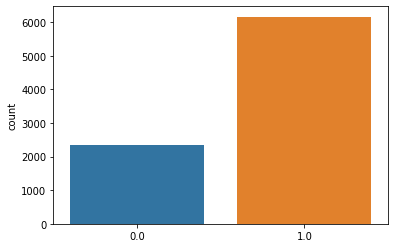

In [7]:
sns.countplot(list(education_mapping.values()));

There are about three times more users with higher education.   
So, an imbalanced data are had to deal with 

So let's look through all files and filter data by function  "select_bank_users_train"

In [8]:
os.chdir(os.path.join(MAIN_PATH, 'parquets'))


def select_bank_users_train(data): return data[data['user_id'].isin(list(education_mapping.keys()))]


train_transactions = Parallel(n_jobs=-1)(delayed(select_bank_users_train)(
    pd.read_parquet(f'bank{i}.parquet', engine='fastparquet')) for i in trange(20))
df_train = pd.concat(train_transactions)

print(f"Shape: {df_train.shape}")
print(f"Memory usage: {df_train.memory_usage().sum() // 1024 ** 2} Mb")

del train_transactions

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.65s/it]


Shape: (7636113, 5)
Memory usage: 349 Mb


Let's check amount of 'mcc_code' unique values

In [9]:
%%time

print(df_train['mcc_code'].nunique())

354
Wall time: 117 ms


'mcc_code' values of train data is less than total 'mcc_code' values

Now it's necessary to load data with test users

In [10]:
%%time
os.chdir(MAIN_PATH)

test_users = pd.read_csv('sample_submission_education.csv', usecols=['bank'])['bank'].unique()
print(f"Amount of unique users: {len(test_users)}")

Amount of unique users: 4000
Wall time: 44 ms


So let's look through all files and filter data by function "select_bank_users_test"

In [11]:
os.chdir(os.path.join(MAIN_PATH, 'parquets'))


def select_bank_users_test(data): return data[data['user_id'].isin(test_users)]


test_transactions = Parallel(n_jobs=-1)(delayed(select_bank_users_test)(
    pd.read_parquet(f'bank{i}.parquet', engine='fastparquet')) for i in trange(20))
df_test = pd.concat(test_transactions)

print(f"Shape: {df_test.shape}")
print(f"Memory usage: {df_test.memory_usage().sum() // 1024 ** 2} Mb")

del test_users, test_transactions 

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Shape: (3626427, 5)
Memory usage: 166 Mb


Let's check amount of 'mcc_code' unique values

In [12]:
%%time

print(df_test['mcc_code'].nunique())

325
Wall time: 68 ms


There are fewer transaction codes in the test data than in the train one.  
I'll use only those transactions that are in both data

Let's select data by 'mcc_code' values that are in both data sets

In [13]:
%%time

selected_mcc = list(set(df_train['mcc_code'].unique()).intersection(set(df_test['mcc_code'].unique())))

df_train = df_train[df_train['mcc_code'].isin(selected_mcc)]
df_test = df_test[df_test['mcc_code'].isin(selected_mcc)]

assert df_train['mcc_code'].nunique() == df_test['mcc_code'].nunique(), 'Количество "mcc_codes" не сходится...'

del selected_mcc

Wall time: 3.26 s


This selection will allow me to receive processed data with the same amount features in both data sets

## 2 Feature engineering and it transformation

It's time to generate new features

In [14]:
%%time

df_train = gen_features(df_train)
print(20*'-')
df_test = gen_features(df_test)

Shape: (8509, 942)
Memory usage: 25 Mb
--------------------
Shape: (4000, 942)
Memory usage: 12 Mb
Wall time: 14.1 s


Let's set target values for train data

In [15]:
df_train['higher_education'] = [education_mapping[idx] for idx in tqdm(df_train.index)]

del education_mapping

100%|██████████████████████████████████████████████████████████████████████████| 8509/8509 [00:00<00:00, 656621.21it/s]


It was found that binaziration of 'count' features allow to increase score. So let's produce this operation

In [16]:
get_dummies = binarize_count_features(df_train)

for col in get_dummies:
    df_test[col] = np.where(df_test[col]>0, 1, 0)
    df_test[col] = df_test[col].astype('int8')
print(f"Memory usage: {df_test.memory_usage().sum() // 1024 ** 2} Mb")

del get_dummies, col

Total amount of 'count' features: 314


314it [00:03, 85.11it/s] 


Binarized: 241
Memory usage: 23 Mb
Memory usage: 11 Mb


Our data is ready to auto machine learning

## 3 Auto machine learning (LightAutoML)

In this track I tried to apply auto machine learning approach.  
I used lightautoml from SberAI.

Time of auto machine learning was set to 2 hours in hope to receive high scores

In [17]:
automl = TabularUtilizedAutoML(
    task=Task('binary', loss='logloss', metric='auc'),
    timeout=7200,
    cpu_limit=2,
    reader_params={'n_jobs': 2, 'cv': 5, 'random_state': 42, 'verbose': 1}
)

oof_pred = automl.fit_predict(
    df_train,
    roles={'target': 'higher_education'},
    verbose=1
)

[19:58:26] Start automl utilizator with listed constraints:
[19:58:26] - time: 7200.00 seconds
[19:58:26] - CPU: 2 cores
[19:58:26] - memory: 16 GB

[19:58:26] If one preset completes earlier, next preset configuration will be started

[19:58:26] ==================================================
[19:58:26] Start 0 automl preset configuration:
[19:58:26] C:\Users\ozher\anaconda3\envs\MyEnv\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[19:58:26] Stdout logging level is INFO.
[19:58:26] Task: binary

[19:58:26] Start automl preset with listed constraints:
[19:58:26] - time: 7199.98 seconds
[19:58:26] - CPU: 2 cores
[19:58:26] - memory: 16 GB

[19:58:26] Train data shape: (8509, 943)

[19:58:57] Layer 1 train process start. Time left 7169.69 secs
[19:58:58] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:59:07] Fitting Lvl_0_Pipe_0_Mod_0_Linea

[20:55:22] Start automl preset with listed constraints:
[20:55:22] - time: 3784.28 seconds
[20:55:22] - CPU: 2 cores
[20:55:22] - memory: 16 GB

[20:55:22] Train data shape: (8509, 943)

[20:55:23] Layer 1 train process start. Time left 3782.74 secs
[20:55:25] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[20:55:33] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7903307475696824
[20:55:33] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[20:55:33] Time left 3773.39 secs

[20:56:49] Selector_LightGBM fitting and predicting completed
[20:56:50] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[21:01:58] Time limit exceeded after calculating fold 3

[21:01:58] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7950342321263052
[21:01:58] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[21:01:58] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
[21:06:09] Hyperparameters optimization for Lvl_0_Pipe_1_

It's time to make probability predictions for test users

In [18]:
%%time

prob_preds = automl.predict(df_test).data
print(len(prob_preds))

4000
Wall time: 15.7 s


## 4 Submit generation

Let's create submission file

In [19]:
os.chdir(MAIN_PATH)

make_submit(df_test, prob_preds)

,bank,higher_education_proba
0,000e0d54d7c945ebb8f6f855972e8396,0.575523
1,001708a5fca04c2ca58d7188b747d5f5,0.887440
2,001c99d8cd6f409f87986b8fba8aa092,0.928007
3,0020536c52ee4257b4619dea899a0cf6,0.692040
4,003d93fb918846ada33fa3977af878eb,0.349857
5,0047dbb5ef764871af8874814ad3be87,0.794621
6,00491339a09c4638a0f27ca51f615d67,0.413134
7,0049c761c1e6468fb6df389dba900ebe,0.483120
8,0056f6f484c543f49cb434c064b5d85a,0.834504
9,006415c4240844e0810617ecebbd2db4,0.396748


Done


I made a great amount of attempts to receive high score.

My the best attempt has following scores:

- [public]: 0.790160 (roc_auc) (33 at leaderboard);
- [private]: 0.785577 (roc_auc) (39 at leaderboard)

There were drift relative to place at the leaderboard and drawdown by scores.

----------------